# A.3 : classification problem, Graph Convolutional Network, impact of mutational signatures
In this notebook, we compare, for the classification problem with the Graph Convolutional Network, the following configurations :
- without mutational signatures (only biomarkers from the reference article : https://doi.org/10.1158/1078-0432.CCR-20-1163)
- with only mutational signatures
- with combination of reference article biomarkers and the mutational signatures

## Table of contents

1. [No mutational signatures](#1-no-sigmut)
2. [Only mutational signatures](#2-only-sigmut)
3. [Initial biomarkers + mutational signatures](#3-not-normalized-sigmut)
4. [Evaluate performances](#4-performances)

In [1]:
# Move to the root of the repository
import sys
sys.path.append("..")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from src.evaluation.ClassificationMetrics import ClassificationMetrics

from src.manage.GNNClassifierTrainTestManager import GNNClassifierTrainTestManager

from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.utils import from_networkx

from src.utils.FeatureSelector import FeatureSelector
from src.utils.PreProcessor import PreProcessor

#### Set hyper-parameters

In [3]:
n_features = 6
n_epochs = 100
lr = 0.005
reg = 0.005
max_neighbors = 2
architecture = 'gcn'
threshold = 0.5

#### Reading and PreProcessor

In [4]:
# Reading dataset
df = pd.read_excel('../data/cohort-dataset.xlsx')

# Drop non naive patients
df = df.loc[df["Cohort"] == "Naive"]

# Drop NaN values
df = PreProcessor.delete_nan_values(df)

# Relabel patients (t = 183 days = 6 months)
t = 183
df = PreProcessor.relabel_patients(df, "Progression_1", "Time to progression (days)", t)

# Normalize initial biomarkers
features_to_normalize = ["Age at advanced disease diagnosis",
                         "CD8+ T cell score",
                         "Genome mut per mb",
                         "Exome mut per mb",
                         "CD274 expression",
                         "M1M2 expression"]

df.loc[:, features_to_normalize] = PreProcessor.normalize_data(df.loc[:, features_to_normalize])

# Select group
group = df["Tumour type"].to_numpy()

# Extract labels
y = df["Progression_1"].to_numpy()

### 1. No mutational signatures

#### Feature selection

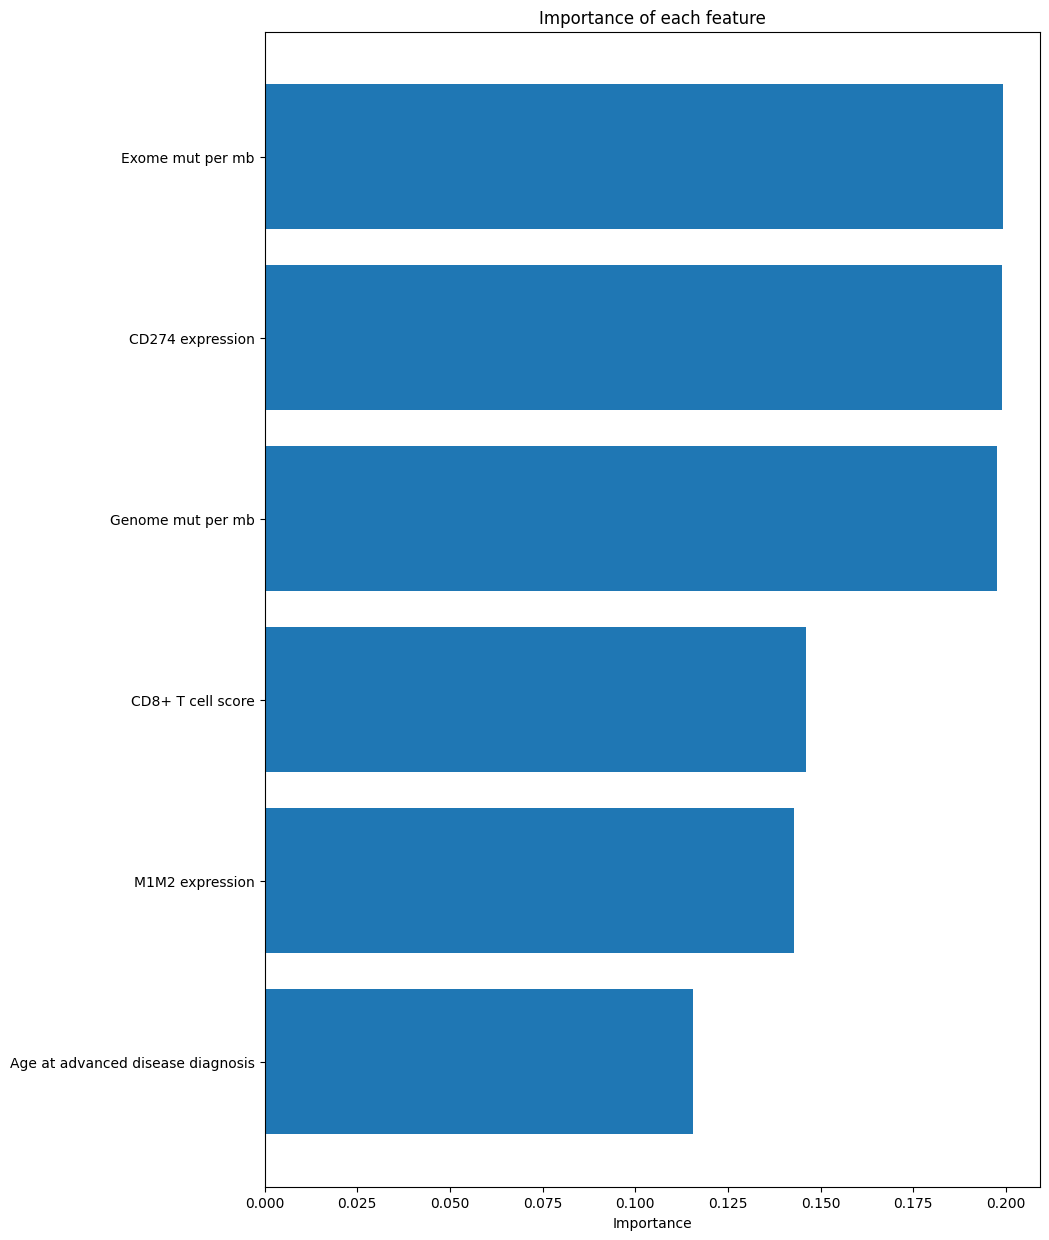

In [5]:
features_name_no_sigmut = ["Age at advanced disease diagnosis",
                           "CD8+ T cell score",
                           "Genome mut per mb",
                           "Exome mut per mb",
                           "CD274 expression",
                           "M1M2 expression"]

# Compute feature importance
features_name_no_sigmut = FeatureSelector.feature_importance(df.loc[:, features_name_no_sigmut], y, True)

# Select the most n_features important features
if n_features < len(features_name_no_sigmut):
    features_name_no_sigmut = features_name_no_sigmut[:n_features]

# Extract features
X_no_sigmut = df.loc[:, features_name_no_sigmut].to_numpy()

#### Execute the leave one out CV

In [6]:
manager_no_sigmut = GNNClassifierTrainTestManager(architecture)
scores_no_sigmut, classes_no_sigmut, train_loss_no_sigmut, val_loss_no_sigmut, nx_graph_no_sigmut = manager_no_sigmut.leave_one_out_cv(X_no_sigmut, y, group, n_epochs, lr, reg, max_neighbors, threshold)

### 2. Only mutational signatures

#### Feature selection

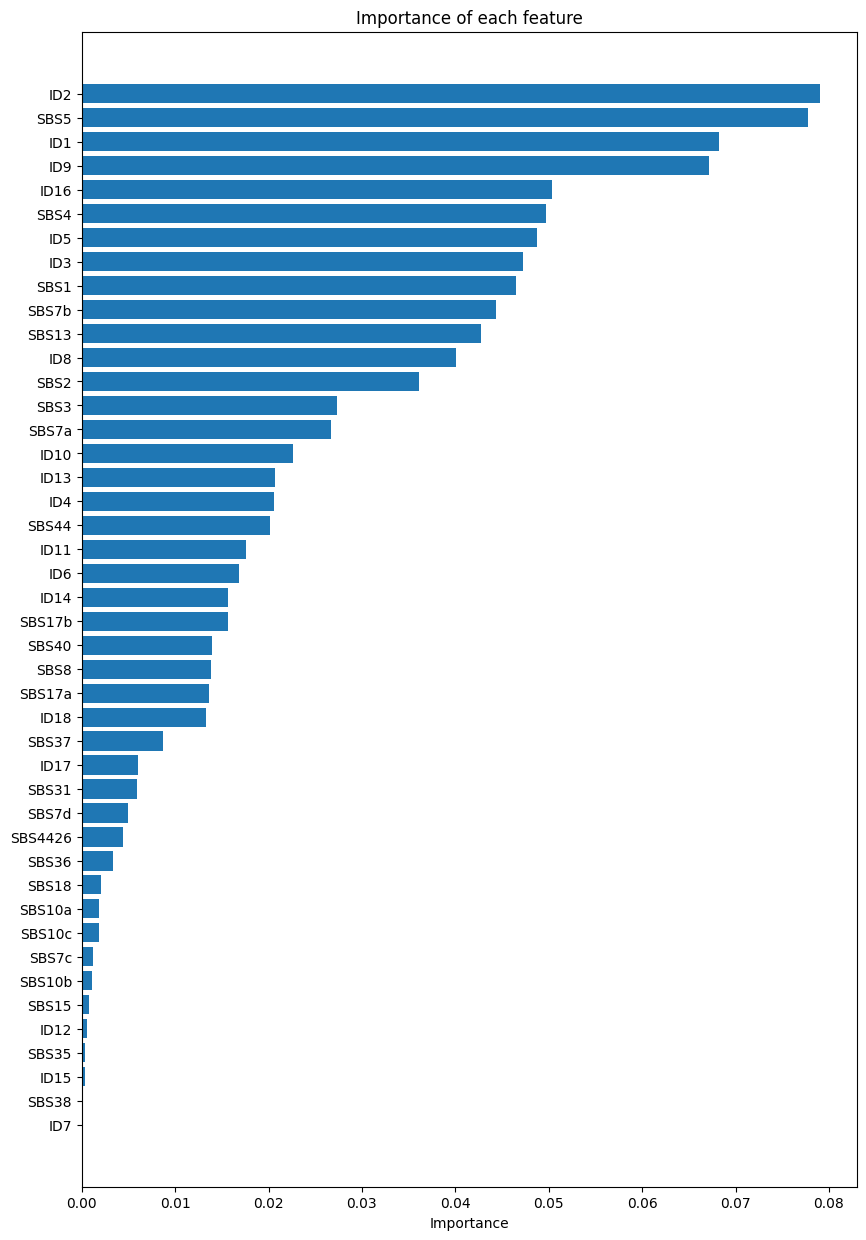

In [7]:
features_name_only_sigmut = ["SBS1",
                             "SBS2",
                             "SBS3",
                             "SBS4",
                             "SBS5",
                             "SBS7a",
                             "SBS7b",
                             "SBS7c",
                             "SBS7d",
                             "SBS8",
                             "SBS10a",
                             "SBS10b",
                             "SBS10c",
                             "SBS13",
                             "SBS15",
                             "SBS17a",
                             "SBS17b",
                             "SBS18",
                             "SBS31",
                             "SBS35",
                             "SBS36",
                             "SBS37",
                             "SBS38",
                             "SBS40",
                             "SBS44",
                             "SBS4426",
                             "ID1",
                             "ID2",
                             "ID3",
                             "ID4",
                             "ID5",
                             "ID6",
                             "ID7",
                             "ID8",
                             "ID9",
                             "ID10",
                             "ID11",
                             "ID12",
                             "ID13",
                             "ID14",
                             "ID15",
                             "ID16",
                             "ID17",
                             "ID18"]

# Compute feature importance
features_name_only_sigmut = FeatureSelector.feature_importance(df.loc[:, features_name_only_sigmut], y, True)

# Select the most n_features important features
if n_features < len(features_name_only_sigmut):
    features_name_only_sigmut = features_name_only_sigmut[:n_features]

# Extract features
X_only_sigmut = df.loc[:, features_name_only_sigmut].to_numpy()

#### Execute the leave one out CV

In [8]:
manager_only_sigmut = GNNClassifierTrainTestManager(architecture)
scores_only_sigmut, classes_only_sigmut, train_loss_only_sigmut, val_loss_only_sigmut, nx_graph_only_sigmut = manager_only_sigmut.leave_one_out_cv(X_only_sigmut, y, group, n_epochs, lr, reg, max_neighbors, threshold)

### 3. Initial biomarkers + mutational signatures

#### Feature selection

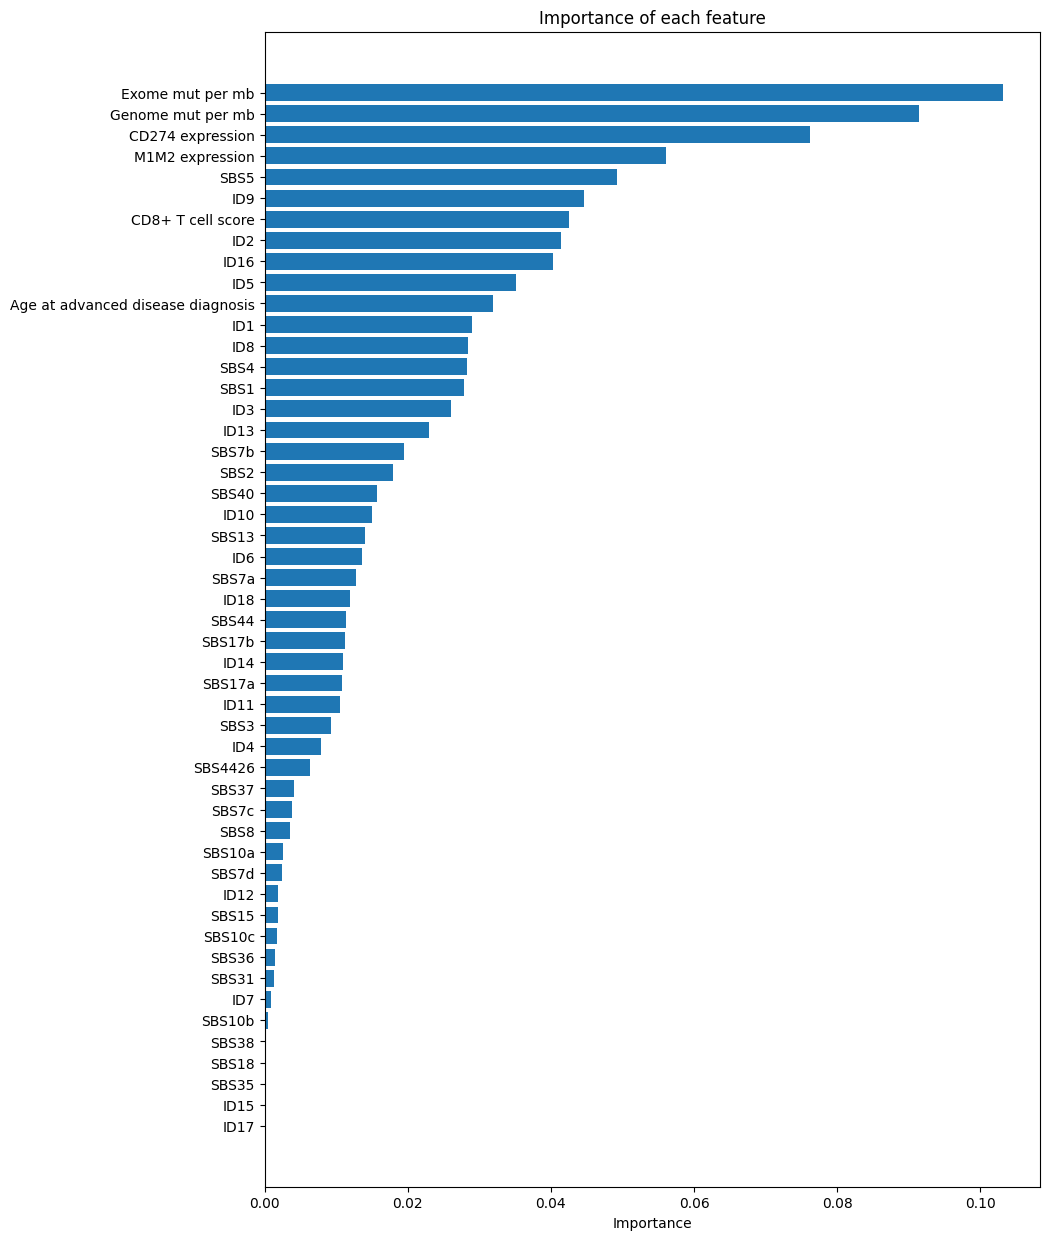

In [9]:
features_name_comb = ["Age at advanced disease diagnosis",
                      "CD8+ T cell score",
                      "Genome mut per mb",
                      "Exome mut per mb",
                      "CD274 expression",
                      "M1M2 expression",
                      "SBS1",
                      "SBS2",
                      "SBS3",
                      "SBS4",
                      "SBS5",
                      "SBS7a",
                      "SBS7b",
                      "SBS7c",
                      "SBS7d",
                      "SBS8",
                      "SBS10a",
                      "SBS10b",
                      "SBS10c",
                      "SBS13",
                      "SBS15",
                      "SBS17a",
                      "SBS17b",
                      "SBS18",
                      "SBS31",
                      "SBS35",
                      "SBS36",
                      "SBS37",
                      "SBS38",
                      "SBS40",
                      "SBS44",
                      "SBS4426",
                      "ID1",
                      "ID2",
                      "ID3",
                      "ID4",
                      "ID5",
                      "ID6",
                      "ID7",
                      "ID8",
                      "ID9",
                      "ID10",
                      "ID11",
                      "ID12",
                      "ID13",
                      "ID14",
                      "ID15",
                      "ID16",
                      "ID17",
                      "ID18"]

# Compute feature importance
features_name_comb = FeatureSelector.feature_importance(df.loc[:, features_name_comb], y, True)

# Select the most n_features important features
if n_features < len(features_name_comb):
    features_name_comb = features_name_comb[:n_features]

# Extract features
X_comb = df.loc[:, features_name_comb].to_numpy()

#### Execute the leave one out CV

In [10]:
manager_comb = GNNClassifierTrainTestManager(architecture)
scores_comb, classes_comb, train_loss_comb, val_loss_comb, nx_graph_comb = manager_comb.leave_one_out_cv(X_comb, y, group, n_epochs, lr, reg, max_neighbors, threshold)

### 4. Evaluate performances

#### Classification metrics

In [11]:
# No mutational signatures
fpr_no_sigmut, tpr_no_sigmut = ClassificationMetrics.compute_roc_curve(y, scores_no_sigmut)
sensitivity_no_sigmut, specificity_no_sigmut = ClassificationMetrics.compute_sensitivity_specificity(y,classes_no_sigmut)
auc_no_sigmut = ClassificationMetrics.compute_auc(y,scores_no_sigmut)

# Only mutational signatures
fpr_only_sigmut, tpr_only_sigmut = ClassificationMetrics.compute_roc_curve(y, scores_only_sigmut)
sensitivity_only_sigmut, specificity_only_sigmut = ClassificationMetrics.compute_sensitivity_specificity(y,classes_only_sigmut)
auc_only_sigmut = ClassificationMetrics.compute_auc(y,scores_only_sigmut)

# Initial biomarkers + mutational signatures
fpr_comb, tpr_comb = ClassificationMetrics.compute_roc_curve(y, scores_comb)
sensitivity_comb, specificity_comb = ClassificationMetrics.compute_sensitivity_specificity(y,classes_comb)
auc_comb = ClassificationMetrics.compute_auc(y,scores_comb)

#### SHAP values

In [12]:
# No sigmut
pyg_graph_no_sigmut = from_networkx(nx_graph_no_sigmut)
explainer_no_sigmut = Explainer(
    model=manager_no_sigmut.model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='probs',  
    ),
)
explanation_no_sigmut = explainer_no_sigmut(pyg_graph_no_sigmut.x, pyg_graph_no_sigmut.edge_index)

# Only sigmut
pyg_graph_only_sigmut = from_networkx(nx_graph_only_sigmut)
explainer_only_sigmut = Explainer(
    model=manager_only_sigmut.model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='probs',  
    ),
)
explanation_only_sigmut = explainer_only_sigmut(pyg_graph_only_sigmut.x, pyg_graph_only_sigmut.edge_index)

# sigmut + others
pyg_graph_comb = from_networkx(nx_graph_comb)
explainer_comb = Explainer(
    model=manager_comb.model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='probs',  
    ),
)
explanation_comb = explainer_comb(pyg_graph_comb.x, pyg_graph_comb.edge_index)


#### Plot results

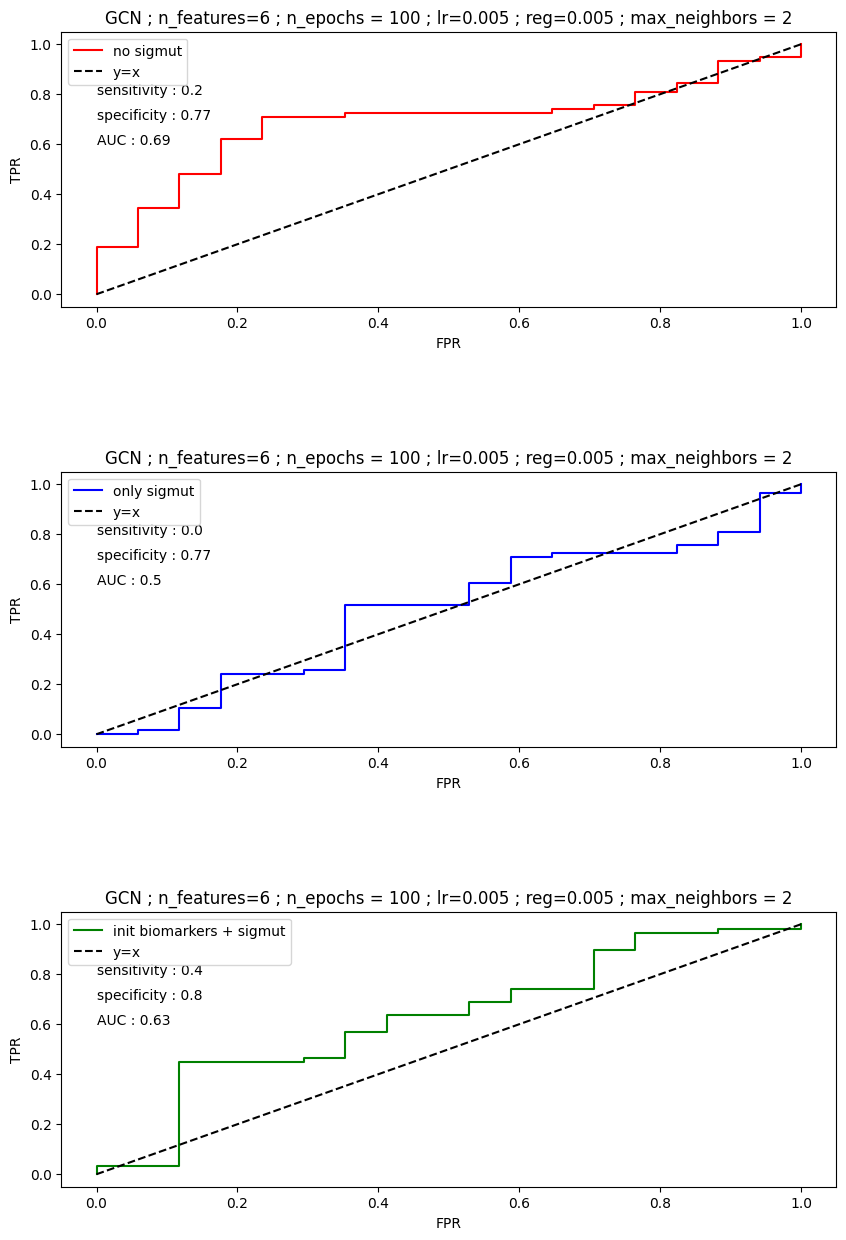

In [13]:
fig = plt.figure()
x = np.linspace(0,1,100)

# No sigmut
ax0 = fig.add_subplot(311)
ax0.plot(fpr_no_sigmut, tpr_no_sigmut, color='red',label='no sigmut')
ax0.plot(x,x,linestyle='--',color='black',label='y=x')
ax0.set_xlabel("FPR")
ax0.set_ylabel("TPR")
ax0.set_title(f"GCN ; n_features={n_features} ; n_epochs = {n_epochs} ; lr={lr} ; reg={reg} ; max_neighbors = {max_neighbors}")
ax0.text(0,0.8,f"sensitivity : {sensitivity_no_sigmut}")
ax0.text(0,0.7,f"specificity : {specificity_no_sigmut}")
ax0.text(0,0.6,f"AUC : {auc_no_sigmut}")
ax0.legend()

# Only sigmut
ax2 = fig.add_subplot(312)
ax2.plot(fpr_only_sigmut, tpr_only_sigmut, color='blue',label='only sigmut')
ax2.plot(x,x,linestyle='--',color='black',label='y=x')
ax2.set_xlabel("FPR")
ax2.set_ylabel("TPR")
ax2.set_title(f"GCN ; n_features={n_features} ; n_epochs = {n_epochs} ; lr={lr} ; reg={reg} ; max_neighbors = {max_neighbors}")
ax2.text(0,0.8,f"sensitivity : {sensitivity_only_sigmut}")
ax2.text(0,0.7,f"specificity : {specificity_only_sigmut}")
ax2.text(0,0.6,f"AUC : {auc_only_sigmut}")
ax2.legend()

# Initial biomarkers + sigmut
ax4 = fig.add_subplot(313)
ax4.plot(fpr_comb, tpr_comb, color='green',label='init biomarkers + sigmut')
ax4.plot(x,x,linestyle='--',color='black',label='y=x')
ax4.set_xlabel("FPR")
ax4.set_ylabel("TPR")
ax4.set_title(f"GCN ; n_features={n_features} ; n_epochs = {n_epochs} ; lr={lr} ; reg={reg} ; max_neighbors = {max_neighbors}")
ax4.text(0,0.8,f"sensitivity : {sensitivity_comb}")
ax4.text(0,0.7,f"specificity : {specificity_comb}")
ax4.text(0,0.6,f"AUC : {auc_comb}")
ax4.legend()

plt.gcf().set_size_inches(10,15)
plt.subplots_adjust(hspace=0.6,wspace=0.6)
plt.show()

No sigmut :


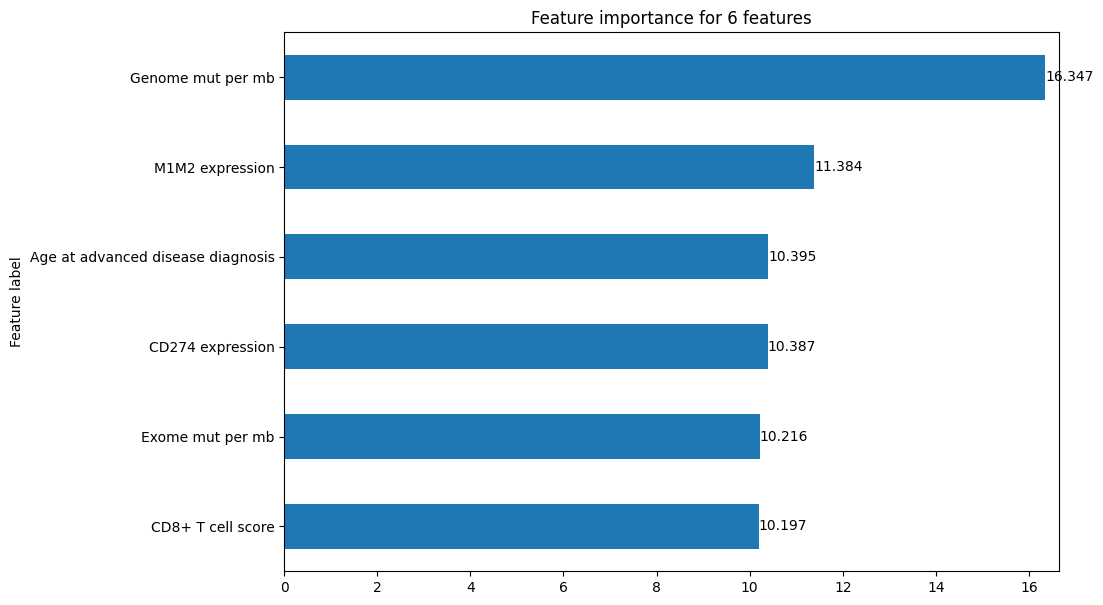

Only sigmut :


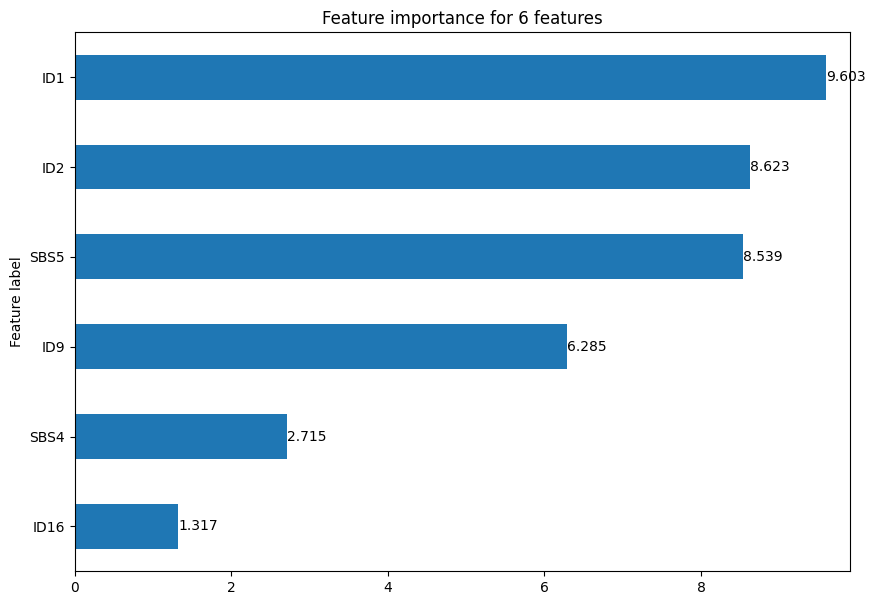

Initial biomarkers + sigmut


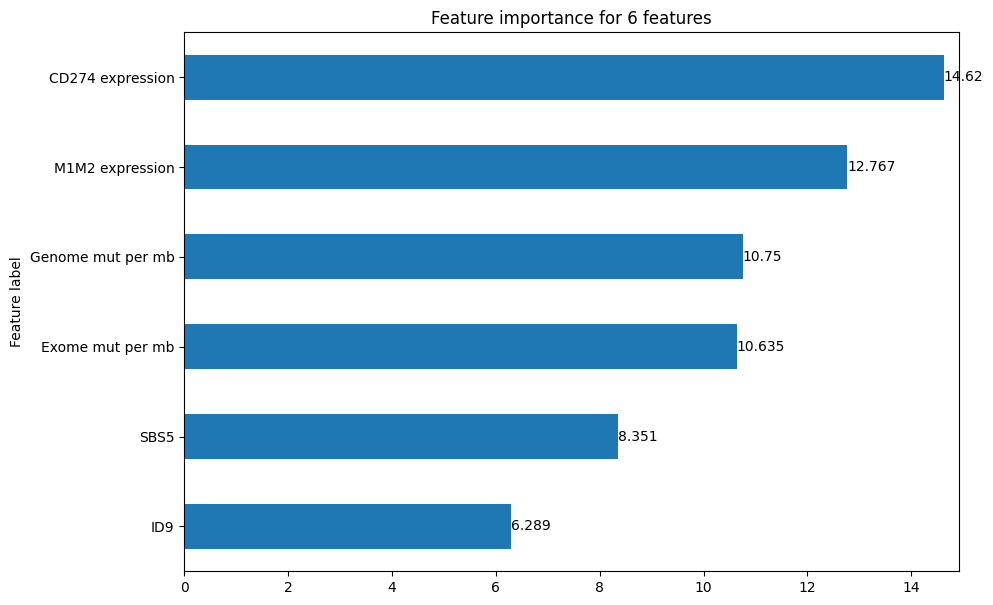

In [14]:
print("No sigmut :")
explanation_no_sigmut.visualize_feature_importance(feat_labels=features_name_no_sigmut)

print("Only sigmut :")
explanation_only_sigmut.visualize_feature_importance(feat_labels=features_name_only_sigmut)

print("Initial biomarkers + sigmut")
explanation_comb.visualize_feature_importance(feat_labels=features_name_comb)

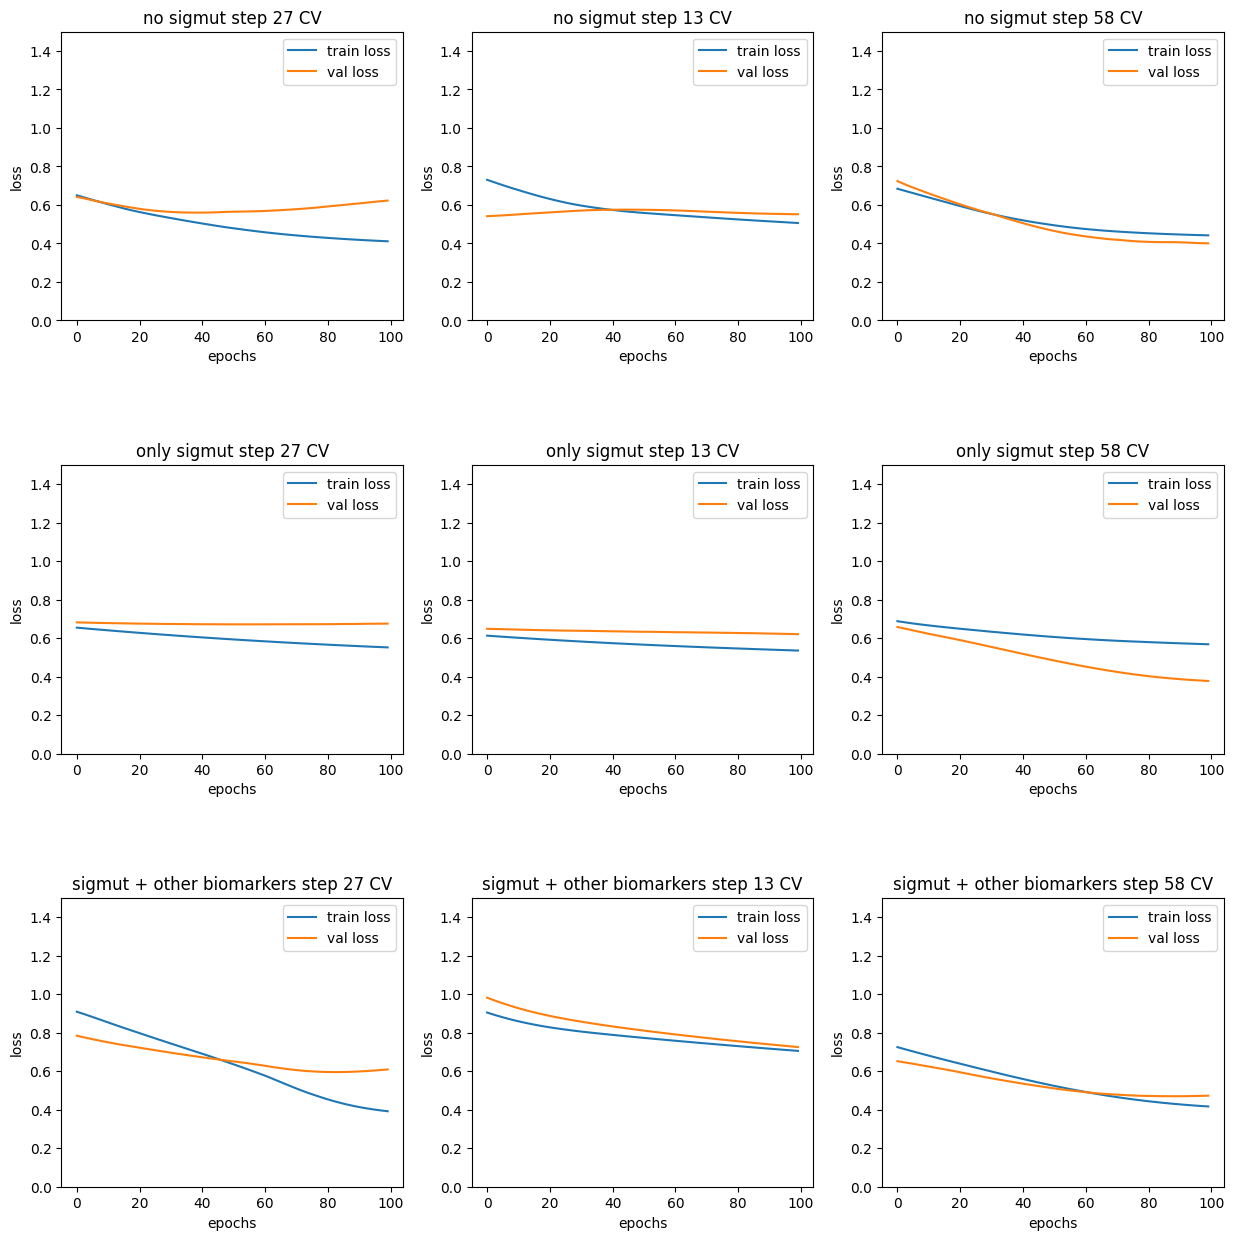

In [15]:
epochs = [k for k in range(n_epochs)]

fig, ax = plt.subplots(3,3,figsize=(15,15))

patient0 = np.random.randint(0,df.shape[0]-1)
patient1 = np.random.randint(0,df.shape[0]-1)
patient2 = np.random.randint(0,df.shape[0]-1)

# No sigmut :
ax[0,0].plot(epochs, train_loss_no_sigmut[patient0],label='train loss')
ax[0,0].plot(epochs, val_loss_no_sigmut[patient0],label='val loss')
ax[0,0].set_xlabel('epochs')
ax[0,0].set_ylabel('loss')
ax[0,0].set_title(f'no sigmut step {patient0} CV')
ax[0,0].set_ylim(0,1.5)
ax[0,0].legend()

ax[0,1].plot(epochs, train_loss_no_sigmut[patient1],label='train loss')
ax[0,1].plot(epochs, val_loss_no_sigmut[patient1],label='val loss')
ax[0,1].set_xlabel('epochs')
ax[0,1].set_ylabel('loss')
ax[0,1].set_title(f'no sigmut step {patient1} CV')
ax[0,1].set_ylim(0,1.5)
ax[0,1].legend()

ax[0,2].plot(epochs, train_loss_no_sigmut[patient2],label='train loss')
ax[0,2].plot(epochs, val_loss_no_sigmut[patient2],label='val loss')
ax[0,2].set_xlabel('epochs')
ax[0,2].set_ylabel('loss')
ax[0,2].set_title(f'no sigmut step {patient2} CV')
ax[0,2].set_ylim(0,1.5)
ax[0,2].legend()

# Only sigmut :
ax[1,0].plot(epochs, train_loss_only_sigmut[patient0],label='train loss')
ax[1,0].plot(epochs, val_loss_only_sigmut[patient0],label='val loss')
ax[1,0].set_xlabel('epochs')
ax[1,0].set_ylabel('loss')
ax[1,0].set_title(f'only sigmut step {patient0} CV')
ax[1,0].set_ylim(0,1.5)
ax[1,0].legend()

ax[1,1].plot(epochs, train_loss_only_sigmut[patient1],label='train loss')
ax[1,1].plot(epochs, val_loss_only_sigmut[patient1],label='val loss')
ax[1,1].set_xlabel('epochs')
ax[1,1].set_ylabel('loss')
ax[1,1].set_title(f'only sigmut step {patient1} CV')
ax[1,1].set_ylim(0,1.5)
ax[1,1].legend()

ax[1,2].plot(epochs, train_loss_only_sigmut[patient2],label='train loss')
ax[1,2].plot(epochs, val_loss_only_sigmut[patient2],label='val loss')
ax[1,2].set_xlabel('epochs')
ax[1,2].set_ylabel('loss')
ax[1,2].set_title(f'only sigmut step {patient2} CV')
ax[1,2].set_ylim(0,1.5)
ax[1,2].legend()

# Sigmut + other biomarkers :
ax[2,0].plot(epochs, train_loss_comb[patient0],label='train loss')
ax[2,0].plot(epochs, val_loss_comb[patient0],label='val loss')
ax[2,0].set_xlabel('epochs')
ax[2,0].set_ylabel('loss')
ax[2,0].set_title(f'sigmut + other biomarkers step {patient0} CV')
ax[2,0].set_ylim(0,1.5)
ax[2,0].legend()

ax[2,1].plot(epochs, train_loss_comb[patient1],label='train loss')
ax[2,1].plot(epochs, val_loss_comb[patient1],label='val loss')
ax[2,1].set_xlabel('epochs')
ax[2,1].set_ylabel('loss')
ax[2,1].set_title(f'sigmut + other biomarkers step {patient1} CV')
ax[2,1].set_ylim(0,1.5)
ax[2,1].legend()

ax[2,2].plot(epochs, train_loss_comb[patient2],label='train loss')
ax[2,2].plot(epochs, val_loss_comb[patient2],label='val loss')
ax[2,2].set_xlabel('epochs')
ax[2,2].set_ylabel('loss')
ax[2,2].set_title(f'sigmut + other biomarkers step {patient2} CV')
ax[2,2].set_ylim(0,1.5)
ax[2,2].legend()
plt.subplots_adjust(hspace=0.5)

Text(0.5, 1.0, 'No sigmut graph used in GCN, max_neighbors=2')

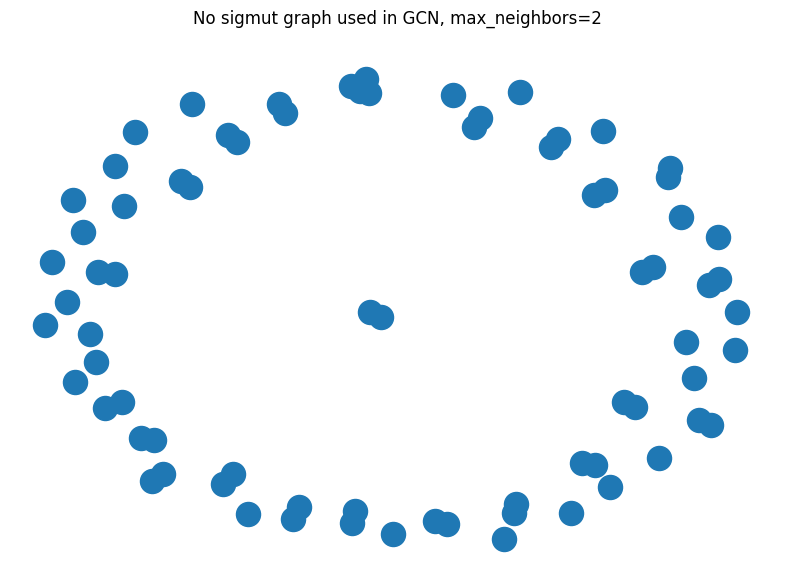

In [16]:
nx_graph_no_sigmut_print = nx_graph_no_sigmut.copy()
for node in list(nx_graph_no_sigmut_print.nodes):
    nx_graph_no_sigmut_print.remove_edge(node,node)

fig, ax = plt.subplots(figsize=(10,7))
nx.draw(nx_graph_no_sigmut_print)
plt.title(f"No sigmut graph used in GCN, max_neighbors={max_neighbors}")

Text(0.5, 1.0, 'Only sigmut graph used in GCN, max_neighbors=2')

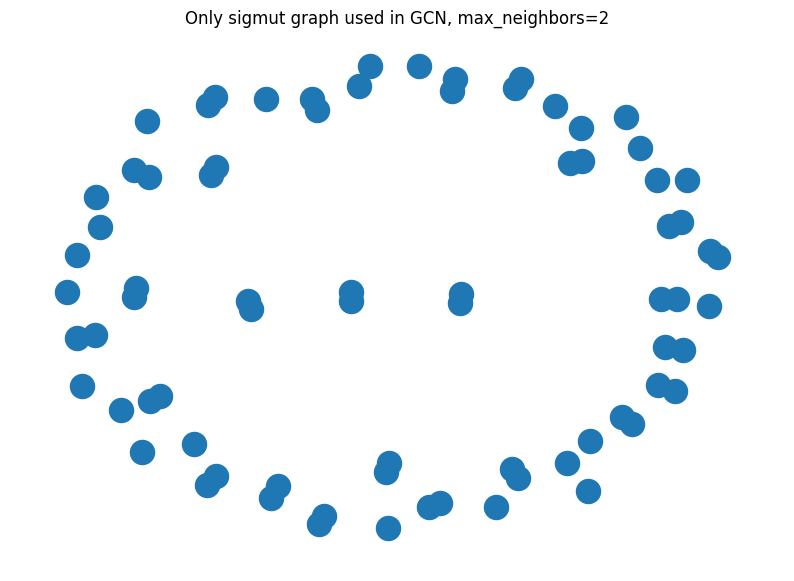

In [17]:
nx_graph_only_sigmut_print = nx_graph_only_sigmut.copy()
for node in list(nx_graph_only_sigmut_print.nodes):
    nx_graph_only_sigmut_print.remove_edge(node,node)

fig, ax = plt.subplots(figsize=(10,7))
nx.draw(nx_graph_only_sigmut_print)
plt.title(f"Only sigmut graph used in GCN, max_neighbors={max_neighbors}")

Text(0.5, 1.0, 'sigmut + others graph used in GCN, max_neighbors=2')

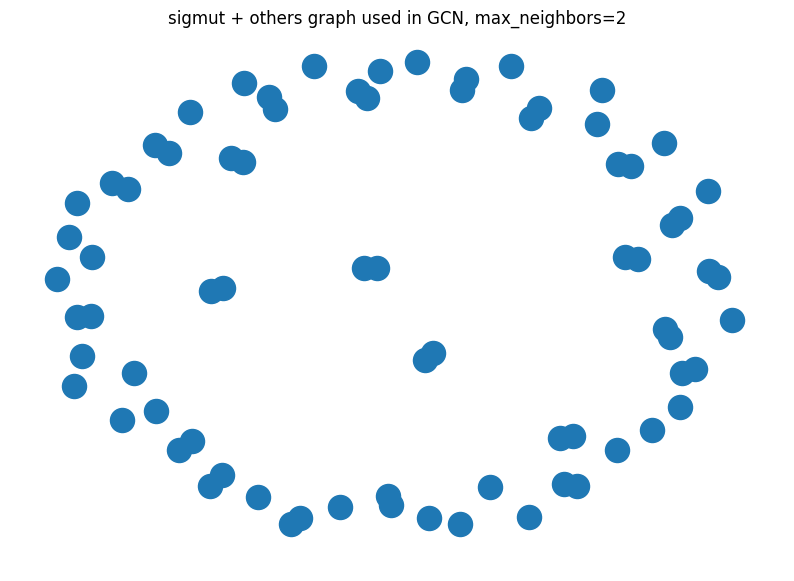

In [18]:
nx_graph_comb_print = nx_graph_comb.copy()
for node in list(nx_graph_comb_print.nodes):
    nx_graph_comb_print.remove_edge(node,node)

fig, ax = plt.subplots(figsize=(10,7))
nx.draw(nx_graph_comb_print)
plt.title(f"sigmut + others graph used in GCN, max_neighbors={max_neighbors}")